# Step estimation for Building 64

This notebook contains all the post-processing steps for the step estimation, based on data gathered in the quarter-circle shaped building 64 of the university


In [300]:
import numpy as np
import pandas as pd
import utils
from scipy import signal 
from matplotlib import pyplot as plt

The preprocessed data is loaded and truncated in such a way that only the first 10 seconds are left, as those are the ones where the phone is stationary. These are then used for estimating `gb_0`.

For more info on the preprocessing, refer to `preprocessing.ipynb`.

In [301]:
#load preprocessed data for calibration
cal_acc = np.load("preprocessed_data/gebaeude64_cali_acc.npy")
acc = np.load("preprocessed_data/gebaeude64_acc_all.npy")
print(acc.shape)
#take the first 10 seconds of the accelerometer (sample freq = 100 hz)
acc = acc[:, :1000]
print(acc.shape)

(4, 19049)
(4, 1000)


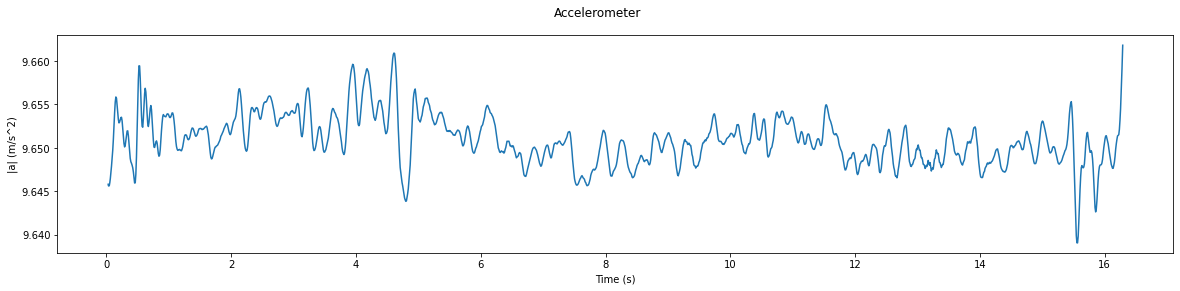

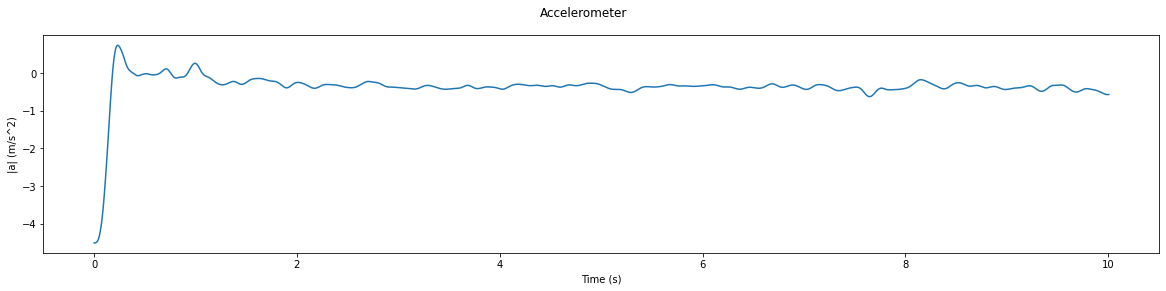

In [302]:
utils.plot_acc(cal_acc, "norm")
utils.plot_acc(acc, "norm")

In [303]:
#estiate g'b(0) by averaging over first ten seconds of accelerometer data
print(acc.shape)
grav = np.mean(acc, axis = 1)

gb_0 = grav[1:]
gb_0

(4, 1000)


array([-0.36929274,  4.47493475,  8.5825164 ])

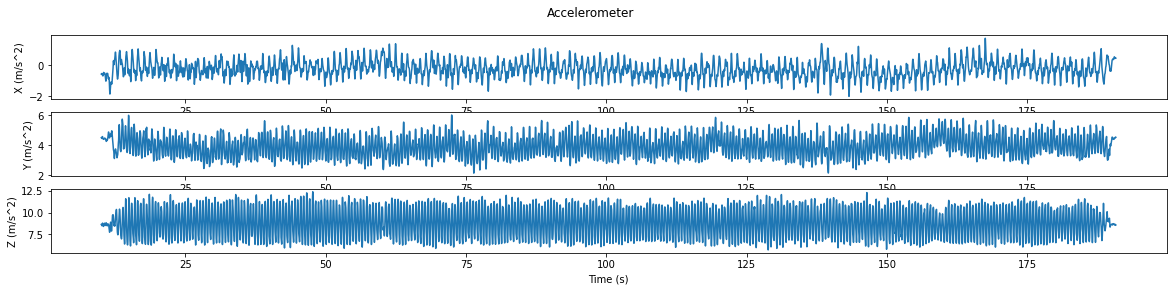

(4, 18049)

In [304]:
acc = np.load("preprocessed_data/gebaeude64_acc_all.npy")
acc = acc[:,1000:]
utils.plot_acc(acc, "all")
acc.shape


The gravity vector is computed for the entire time series, based on a moving average estimation. The implementatation can be found in `utils.py`. A $\sigma$ of 0.7 was chosen for this estimation, but different values have shown little effect on the final result.

In [305]:
#get g for entire time series
g_list = [gb_0]
sigma = 0.7
for t in range(1, acc.shape[1]):
    g_t = utils.get_gb(acc, t, sigma, g_list[-1])
    g_list.append(g_t)

g_array = np.asarray(g_list)
g_array.shape


(18049, 3)

Based on the estimations of the gravity vector, the base shift matrices are calculated. 

In [306]:
# compute base shift matrix for entire series
R_list = []
for g in g_array:
    R_list.append(utils.get_matrix(g))

R_array = np.asarray(R_list)
R_array.shape

(18049, 3, 3)

The gyroscope is loaded and truncated in a way that removes the stationary part.

In [307]:
# load gyro data 
gyro = np.load("preprocessed_data/gebaeude64_gyro_all.npy")
gyro = gyro[1:, 1000:].T
gyro.shape

(18042, 3)

The turn rates are estimated using the given formula

In [308]:
# calcuate all turn rates
turn_rate_list = []
for t in range(gyro.shape[0]):
    turn_rate_list.append(R_array[t].T @ gyro[t])

turn_rate_array = np.asarray(turn_rate_list)
turn_rate_array.shape

(18042, 3)

The turn angles are calculated based on the turn rates. The $\Delta_t$ should be equal to the frequency of the recording device. However, it seems that either the device or the application does not accurately measure the frequency, as using a $\Delta_t$ equal to 1/100hz did not give accurate results. The final $\Delta_t$ used correspons to a frequency of about 75hz. This parameter was the most important in achieving good results.

In [309]:
# get turn angles
delta_t = 0.0133 #100hz sample frequency

turn_angles = []

for t in range(turn_rate_array.shape[0]):
    turn_angles.append(turn_rate_array[:t].sum(axis = 0))

turn_angle_array = np.asarray(turn_angles) * delta_t
#turn_angle_array = np.linalg.norm(turn_rate_array, axis = 1)
turn_angle_array.shape


(18042, 3)

The accelerometer dats is loaded and truncated once again. Then we use the `find_peaks` function from *scipy's signal* library to find the peaks in the accelerometer. (For a visualisation, refer back to `preprocessing.ipynb`)

In [310]:
# get peaks from accelerometer

acc = np.load("preprocessed_data/gebaeude64_acc.npy")

acc = acc[:, 1000:]

# find peaks
peaks, _ = signal.find_peaks(acc[1], height=10.5)


For every peak in the peaks found in the previous step, the turn angle is taken from the array and the step in 2D-space is computed, based on the angle, the step size and the previous step.

In [311]:
step_size = 70

x = np.array([0])
y = np.array([0])

for peak in peaks:
    x = np.append(x, x[-1] + step_size * np.cos(turn_angle_array[peak]))
    y = np.append(y, y[-1] + step_size * np.sin(turn_angle_array[peak]))



The trajectory is plotted. As can be seen, the results are fairly accurate. No GPS data has been acquired to check if the distances are also accurate. However, as this would just be an adjustment in the step size anyway it is not of great importance.

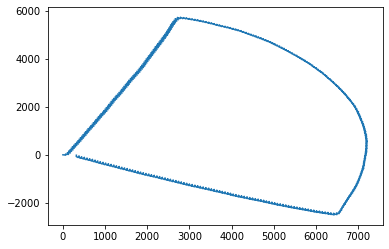

In [312]:
plt.plot(x,y)
plt.show()

array([0.03194309, 0.0295146 , 0.02744966, ..., 0.04342893, 0.0459457 ,
       0.0473342 ])